In [1]:
import sys
import theano
import theano.tensor as T
from theano.tensor.signal.downsample import max_pool_2d
import numpy 
from get_datastream import get_datastream
theano.config.floatX='float32'


/Users/patricklau/anaconda3/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
# Get datastreams
image_size = (256,256)
mhratio = 1.5
min_dim_size = 270
batch_size = 64 
train_stream = get_datastream(image_size,mhratio,min_dim_size,batch_size,"train")
valid_stream = get_datastream(image_size,mhratio,min_dim_size,batch_size,"valid")
test_stream = get_datastream(image_size,mhratio,min_dim_size,batch_size,"test")
num_t_batches = 20000/batch_size
num_v_batches = 2500/batch_size



In [12]:

class LeNetConvPoolLayer(object):
    """Pool Layer of a convolutional network """

    def __init__(self, rng, input, filter_shape, image_shape, poolsize=(2, 2),
                 W_values=None,b_values=None):
        """
        Allocate a LeNetConvPoolLayer with shared variable internal parameters.

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dtensor4
        :param input: symbolic image tensor, of shape image_shape

        :type filter_shape: tuple or list of length 4

        :param filter_shape: (number of filters, num input feature maps,
                              filter height, filter width)

        :type image_shape: tuple or list of length 4
        :param image_shape: (batch size, num input feature maps,
                             image height, image width)

        :type poolsize: tuple or list of length 2
        :param poolsize: the downsampling (pooling) factor (#rows, #cols)
        
        :type W_values: numpy array of shape filter_shape
        :param W_values: initiated randomly if not supplied 
        """

        assert image_shape[1] == filter_shape[1]
        self.input = input

        # there are "num input feature maps * filter height * filter width"
        # inputs to each hidden unit
        fan_in = numpy.prod(filter_shape[1:])

        # initialize weights with random weights
        W_bound = numpy.sqrt(2 / (fan_in))
        W_bound = 0.02
        if W_values is None:
            W_values = numpy.asarray(
                       rng.standard_normal(size=filter_shape)*W_bound,
                       dtype=theano.config.floatX
                       )
        else:
            W_values = numpy.asarray(W_values,dtype=theano.config.floatX)
        
        self.W = theano.shared(W_values,borrow=True)

        # the bias is a 1D tensor -- one bias per output feature map
        if b_values is None:
            b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
        else:
            b_values = numpy.asarray(b_values,dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, borrow=True)

        # convolve input feature maps with filters
        conv_out = T.nnet.conv2d(
            input=input,
            filters=self.W,
            filter_shape=filter_shape,
            image_shape=image_shape,
            border_mode="half"
        )
        
        # non-linear activation (relu)
        # add the bias term. Since the bias is a vector (1D array), we first
        # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
        # thus be broadcasted across mini-batches and feature map
        # width & height
        
        activation = T.nnet.relu(conv_out + self.b.dimshuffle('x',0,'x','x'))
        
        # downsample each feature map individually, using maxpooling
        self.output = max_pool_2d(
            input=activation,
            ds=poolsize,
            ignore_border=True
        )

        # store parameters of this layer
        self.params = [self.W, self.b]

class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W_values=None, b_values=None,
                 activation=T.nnet.relu):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dmatrix
        :param input: a symbolic tensor of shape (n_examples, n_in)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: theano.Op or function
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input = input
        # end-snippet-1

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # for tanh activation function
        # the output of uniform if converted using asarray to dtype
        # theano.config.floatX so that the code is runable on GPU
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        if W_values is None:
            W_values = numpy.asarray(
                #rng.standard_normal(size=(n_in, n_out))*numpy.sqrt(2./n_in),
                rng.standard_normal(size=(n_in, n_out))*0.02,
                dtype=theano.config.floatX
            )
        else:
            W_values = numpy.asarray(W_values,dtype=theano.config.floatX)
        W = theano.shared(value=W_values, name='W', borrow=True)

        if b_values is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
        else:
            b_values = numpy.asarray(W_values,dtype=theano.config.floatX)
        b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b 
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]


class LogisticRegression(object):
    """Multi-class Logistic Regression Class

    The logistic regression is fully described by a weight matrix :math:`W`
    and bias vector :math:`b`. Classification is done by projecting data
    points onto a set of hyperplanes, the distance to which is used to
    determine a class membership probability.
    """

    def __init__(self, input, n_in, n_out,W_values=None,b_values=None):
        """ Initialize the parameters of the logistic regression

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
                      architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
                     which the datapoints lie

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
                      which the labels lie

        """
        # start-snippet-1
        # initialize with 0 the weights W as a matrix of shape (n_in, n_out)
        if W_values is None:
            W_values = numpy.zeros((n_in, n_out),dtype=theano.config.floatX)
        else:
            W_values = numpy.asarry(W_values,dtype=theano.config.floatX)
        self.W = theano.shared(
            value=W_values,
            name='W',
            borrow=True
        )
        # initialize the baises b as a vector of n_out 0s
        if b_values is None:
            b_values = numpy.zeros((n_out,),dtype=theano.config.floatX)
        else:
            b_values = numpy.asarray(b_values,dtype=theano.config.floatX)
        self.b = theano.shared(
            value=b_values,
            name='b',
            borrow=True
        )

        # symbolic expression for computing the matrix of class-membership
        # probabilities
        # Where:
        # W is a matrix where column-k represent the separation hyper plain for
        # class-k
        # x is a matrix where row-j  represents input training sample-j
        # b is a vector where element-k represent the free parameter of hyper
        # plain-k
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)
        # symbolic description of how to compute prediction as class whose
        # probability is maximal
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)
        # end-snippet-1

        # parameters of the model
        self.params = [self.W, self.b]

    def negative_log_likelihood(self, y):
        """Return the mean of the negative log-likelihood of the prediction
        of this model under a given target distribution.

        .. math::

            \frac{1}{|\mathcal{D}|} \mathcal{L} (\theta=\{W,b\}, \mathcal{D}) =
            \frac{1}{|\mathcal{D}|} \sum_{i=0}^{|\mathcal{D}|}
                \log(P(Y=y^{(i)}|x^{(i)}, W,b)) \\
            \ell (\theta=\{W,b\}, \mathcal{D})

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label

        Note: we use the mean instead of the sum so that
              the learning rate is less dependent on the batch size
        """
        # start-snippet-2
        # y.shape[0] is (symbolically) the number of rows in y, i.e.,
        # number of examples (call it n) in the minibatch
        # T.arange(y.shape[0]) is a symbolic vector which will contain
        # [0,1,2,... n-1] T.log(self.p_y_given_x) is a matrix of
        # Log-Probabilities (call it LP) with one row per example and
        # one column per class LP[T.arange(y.shape[0]),y] is a vector
        # v containing [LP[0,y[0]], LP[1,y[1]], LP[2,y[2]], ...,
        # LP[n-1,y[n-1]]] and T.mean(LP[T.arange(y.shape[0]),y]) is
        # the mean (across minibatch examples) of the elements in v,
        # i.e., the mean log-likelihood across the minibatch.
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])
        # end-snippet-2

    def errors(self, y):
        """Return a float representing the number of errors in the minibatch
        over the total number of examples of the minibatch ; zero one
        loss over the size of the minibatch

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label
        """

        # check if y has same dimension of y_pred
        if y.ndim != self.y_pred.ndim:
            raise TypeError(
                'y should have the same shape as self.y_pred',
                ('y', y.type, 'y_pred', self.y_pred.type)
            )
        # check if y is of the correct datatype
        if y.dtype.startswith('int'):
            # the T.neq operator returns a vector of 0s and 1s, where 1
            # represents a mistake in prediction
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()





nkerns=[32,64,128,256]




rng = numpy.random.RandomState(23455)

 
x = T.tensor4('x')
y = T.lvector('y')

######################
# BUILD ACTUAL MODEL #
######################

# Construct the first convolutional pooling layer:
# filtering keeps the image size as (256, 256) 
# maxpooling reduces this further to (256/2, 256/2) = (128, 128)
# 4D output tensor is thus of shape (batch_size, nkerns[0], 128, 128)
layer0 = LeNetConvPoolLayer(
    rng,
    input=x,
    image_shape=(batch_size, 3, 256, 256),
    filter_shape=(nkerns[0], 3, 3, 3),
    poolsize=(2, 2)
)

# Construct the second convolutional pooling layer
# filtering keeps the image size as (128, 128) = (128, 128)
# maxpooling reduces this further to (128/2, 128/2) = (64, 64)
# 4D output tensor is thus of shape (batch_size, nkerns[1], 64, 64)
layer1 = LeNetConvPoolLayer(
    rng,
    input=layer0.output,
    image_shape=(batch_size, nkerns[0], 128, 128),
    filter_shape=(nkerns[1], nkerns[0], 3, 3),
    poolsize=(2, 2)
)

# Construct the third convolutional pooling layer
# filtering keeps the image size as (64, 64) = (64, 64)
# maxpooling reduces this further to (64/2, 64/2) = (32, 32)
# 4D output tensor is thus of shape (batch_size, nkerns[2], 32, 32)
layer2 = LeNetConvPoolLayer(
    rng,
    input=layer1.output,
    image_shape=(batch_size, nkerns[1], 64, 64),
    filter_shape=(nkerns[2], nkerns[1], 3, 3),
    poolsize=(2, 2)
)

# Construct the fourth convolutional pooling layer
# filtering reduces the image size to (32, 32) = (32, 32)
# maxpooling reduces this further to (32/2, 32/2) = (16, 16)
# 4D output tensor is thus of shape (batch_size, nkerns[3], 16, 16)
layer3 = LeNetConvPoolLayer(
    rng,
    input=layer2.output,
    image_shape=(batch_size, nkerns[2], 32, 32),
    filter_shape=(nkerns[3], nkerns[2], 3, 3),
    poolsize=(2, 2)
)


# Construct the fifth convolutional pooling layer
# filtering keeps the image size as (16, 16) = (16, 16)
# maxpooling reduces this further to (16/2, 16/2) = (8, 8)
# 4D output tensor is thus of shape (batch_size, nkerns[3], 8, 8)
layer4 = LeNetConvPoolLayer(
    rng,
    input=layer3.output,
    image_shape=(batch_size, nkerns[3], 16, 16),
    filter_shape=(nkerns[3], nkerns[3], 3, 3),
    poolsize=(2, 2)
)

# the HiddenLayer being fully-connected, it operates on 2D matrices of
# shape (batch_size, num_pixels) (i.e matrix of rasterized images).
# This will generate a matrix of shape (batch_size, nkerns[3] * 8 * 8),
# or (32, 512 * 8 * 8) = (32, 32768) with the default values.
layer5_input = layer4.output.flatten(2)

# construct a fully-connected relu layer
layer5 = HiddenLayer(
    rng,
    input=layer5_input,
    n_in=nkerns[3] * 8 * 8,
    n_out=256,
    activation=T.nnet.relu
)
#layer6_input = layer5.output
# construct a fully-connected relu layer
#layer6 = HiddenLayer(
#    rng,
#    input=layer6_input,
#    n_in=4096,
#    n_out=4096,
#    activation=T.nnet.relu
#)

#layer7_input = layer6.output
# construct a fully-connected relu layer
#layer7 = HiddenLayer(
#    rng,
#    input=layer7_input,
#    n_in=4096,
#    n_out=1000,
#    activation=T.nnet.relu
#)
# classify the values of the fully-connected sigmoidal layer
layer6 = LogisticRegression(input=layer5.output, n_in=256, n_out=2)

# the cost we minimize during training is the NLL of the model
cost = layer6.negative_log_likelihood(y)

# create a function to compute the mistakes that are made by the model
test_model = theano.function(
    [x, y],
    layer6.errors(y)
)

validate_model = theano.function(
    [x, y],
    layer6.errors(y)
)

# create a list of all model parameters to be fit by gradient descent
params = layer6.params + layer5.params + layer4.params + layer3.params + layer2.params + layer1.params + layer0.params
#param_dim = sum([parami.flatten().shape for parami in params]).eval()
param_norm = sum([abs(parami).flatten().sum() for parami in params])
load_from_obj = True
if load_from_obj :
    from six.moves import cPickle
    f = open('obj.save','rb')
    loaded_obj = cPickle.load(f)
    f.close()
    for parami,parami_v in zip(params,loaded_obj):
        parami.set_value(parami_v)
# create a list of gradients for all model parameters
grads = T.grad(cost, params)
grad_norm = sum([abs(gradi).flatten().sum() for gradi in grads])

gradient_feature = None   
alpha = T.scalar('alpha',dtype=theano.config.floatX)
learning_rate = T.scalar('learning_rate',dtype=theano.config.floatX)
#gradient_feature = "momentum"
if(gradient_feature == "momentum"):
    velocity = [theano.shared(numpy.zeros(param_i.get_value().shape,
                                          dtype=theano.config.floatX),
                              borrow=True)
                for param_i in params]
    updates = [(v_i, alpha*v_i-learning_rate*grad_i) 
               for v_i,grad_i in zip(velocity,grads)] + \
              [(param_i,param_i + new_vi) 
               for param_i, new_vi in zip(params,velocity)]
    model_input = [x,y,learning_rate,alpha]
# Implements the Nesterov momentum that only uses the last
# gradient value 
elif(gradient_feature == "nesterov_momentum"):
    velocity = [theano.shared(numpy.zeros(param_i.get_value().shape,
                                          dtype=theano.config.floatX),
                              borrow=True)
            for param_i in params]
    updates = [(v_i, alpha*v_i-learning_rate*grad_i) 
               for v_i,grad_i in zip(velocity,grads)] + \
              [(param_i,param_i + alpha*alpha*new_vi - \
              (1.+alpha)*learning_rate*grad_i)
               for param_i, new_vi, grad_i in zip(params,velocity,grads)]
    model_input = [x,y,learning_rate,alpha]
else:
    updates = [
        (param_i, param_i - learning_rate * grad_i)
        for param_i, grad_i in zip(params, grads)
    ]
    model_input = [x,y,learning_rate]

# train_model is a function that updates the model parameters by
# SGD Since this model has many parameters, it would be tedious to
# manually create an update rule for each model parameter. We thus
# create the updates list by automatically looping over all
# (params[i], grads[i]) pairs.



train_model = theano.function(
    model_input,
    [cost,grad_norm,param_norm],
    updates=updates
)

valid_model = theano.function(
    model_input[:2],
    layer6.errors(y)
)



/Users/patricklau/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:65: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.


In [3]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
batchx,batchy = next(train_stream.get_epoch_iterator())

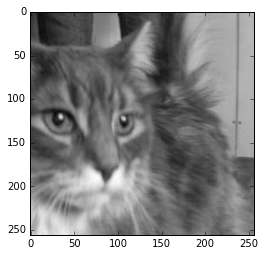

In [82]:
plt.imshow(batchx[0,2],cmap=cm.gray)

In [80]:
l0output=layer0.output.eval({x:batchx})


In [24]:
l0output[0].shape

(32, 128, 128)

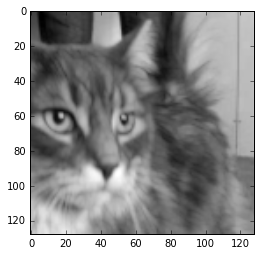

In [86]:
plt.imshow(l0output[0][24],cmap=cm.gray)

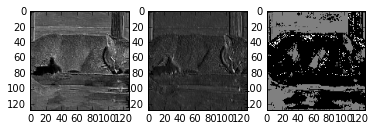

In [91]:
plt.subplot(1,3,1)
plt.imshow(l0output[4][0],cmap=cm.gray)
plt.subplot(1,3,2)
plt.imshow(l0output[4][12],cmap=cm.gray)
plt.subplot(1,3,3)
plt.imshow(l0output[4][26],cmap=cm.gray)




In [34]:
l1output=layer1.output.eval({x:batchx})

In [35]:
l1output[0].shape

(64, 64, 64)

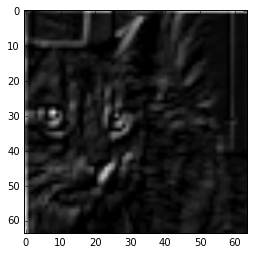

In [89]:
plt.imshow(l1output[0][10],cmap=cm.gray)

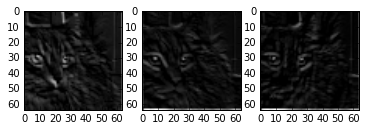

In [37]:
plt.subplot(1,3,1)
plt.imshow(l1output[0][0],cmap=cm.gray)
plt.subplot(1,3,2)
plt.imshow(l1output[0][12],cmap=cm.gray)
plt.subplot(1,3,3)
plt.imshow(l1output[0][26],cmap=cm.gray)





In [63]:
l2output=layer2.output.eval({x:batchx})

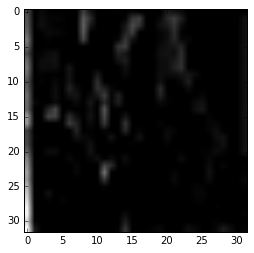

In [67]:
plt.imshow(l2output[0][2],cmap=cm.gray)

In [61]:
l3output=layer3.output.eval({x:batchx})

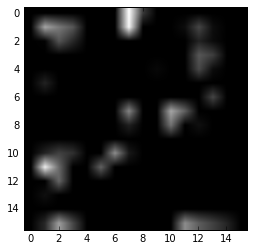

In [62]:
plt.imshow(l3output[0][1],cmap=cm.gray)

In [55]:
l4output=layer4.output.eval({x:batchx})

In [56]:
l4output[0].shape

(256, 8, 8)

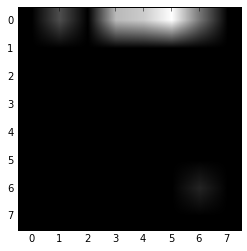

In [58]:
plt.imshow(l4output[0][1],cmap=cm.gray)

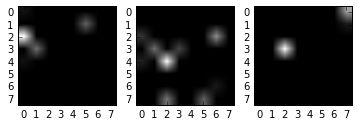

In [90]:
plt.subplot(1,3,1)
plt.imshow(l4output[4][0],cmap=cm.gray)
plt.subplot(1,3,2)
plt.imshow(l4output[4][12],cmap=cm.gray)
plt.subplot(1,3,3)
plt.imshow(l4output[4][23],cmap=cm.gray)




Filters from first layer 

In [40]:
params[12].shape.eval()

array([32,  3,  3,  3])

In [45]:
params[12].get_value()[0][0]

array([[ 0.01533774,  0.04984713,  0.07373299],
       [ 0.03458841, -0.05612936,  0.013008  ],
       [-0.04181516, -0.0667389 ,  0.00625646]], dtype=float32)

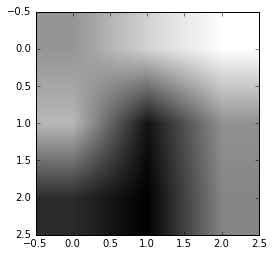

In [47]:
plt.imshow(params[12].get_value()[0][0],cmap=cm.gray)

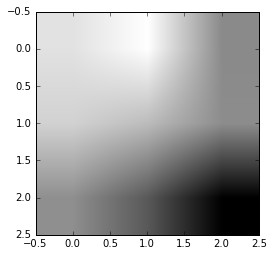

In [48]:
plt.imshow(params[12].get_value()[1][2],cmap=cm.gray)

Filters from Higher layers

In [50]:
params[4].shape.eval()

array([256, 256,   3,   3])

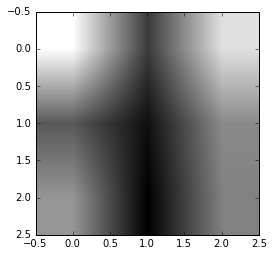

In [51]:
plt.imshow(params[4].get_value()[1][3],cmap=cm.gray)

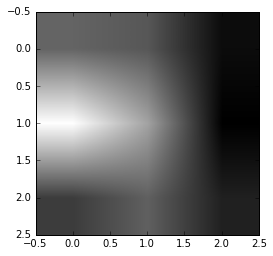

In [52]:
plt.imshow(params[4].get_value()[1][3],cmap=cm.gray)